In [56]:
%matplotlib inline

import os
import torch
import json
import h5py
import numpy as np
import pandas as pd
from os.path import join
import matplotlib
import matplotlib.pyplot as plt

In [57]:
def invert_dict(d):
    return {v: k for k, v in d.items()}

In [58]:
def search_experiments(df, common_hypers):
    """ Find experiments that share identical hyper-parameters
    :param df: pd.DataFrame 
    :param common_hypers: dictionary of hyper-parameters
    :returns: indexes of df
    """
    n_exps = df.shape[0]
    same_exp_array = np.ones(n_exps, dtype=int)
    for id_ in range(n_exps):
        for k_, v_ in common_hypers.items():
            if type(v_) is dict:
                try:
                    same_exp = np.prod(np.array([df.iloc[id_][k_][k__] == v__
                                                 for k__, v__ in v_.items()]))
                except:
                    same_exp = False
            else:
                try:
                    same_exp = v_ == df.iloc[id_][k_]
                except:
                    same_exp = False
            if not same_exp:
                same_exp_array[id_] = same_exp
                break
    return np.squeeze(np.argwhere(same_exp_array))

In [59]:
def find_best_experiment(df, indexes):
    """
    :param df: pd.DataFrame
    :param indexes: indexes for experiments that are comparable
    :return: tuple, index for the best experiment, best validation accuracy
    
    THE BEST VALIDATION IS ESTIMATED ON THE 1k SAMPLES FROM THE VALIDATION SET
    """
    path_list = [df["output_path"][k_] for k_ in indexes]
    max_list = []

    for id_, path_ in enumerate(path_list):
        json_output = json.load(open(join(path_, "model.json"), "rb"))
        max_list.append((np.max(np.array(json_output["val_accs"]))))
    return indexes[np.argmax(max_list)], np.max(max_list)

In [60]:
dct_hyper_method = {"find_w_bn": {"use_module": "find",
                                  "separated_stem": False,
                                  "separated_module": False,
                                  "separated_classifier": False,
                                  "stem_batchnorm": 1,
                                  "classifier_batchnorm": 1},
                    "res_w_bn": {"use_module": "residual",
                                 "separated_stem": False,
                                 "separated_module": False,
                                 "separated_classifier": False,
                                 "stem_batchnorm": 1,
                                 "classifier_batchnorm": 1},
                    "find_wo_bn": {"use_module": "find",
                                   "separated_stem": False,
                                   "separated_module": False,
                                   "separated_classifier": False,
                                   "stem_batchnorm": 0,
                                   "classifier_batchnorm": 0},
                    "res_wo_bn": {"use_module": "residual",
                                  "separated_stem": False,
                                  "separated_module": False,
                                  "separated_classifier": False,
                                  "stem_batchnorm": 0,
                                  "classifier_batchnorm": 0},
                    "half-sep_find": {"use_module": "find",
                                      "separated_stem": False,
                                      "separated_module": True,
                                      "separated_classifier": True,
                                      "stem_batchnorm": 0,
                                      "classifier_batchnorm": 0},
                    "sep_find": {"use_module": "find",
                                 "separated_stem": True,
                                 "separated_module": True,
                                 "separated_classifier": True,
                                 "stem_batchnorm": 0,
                                 "classifier_batchnorm": 0},
                    "sep_res": {"use_module": "residual",
                                "separated_stem": True,
                                "separated_module": True,
                                "separated_classifier": True,
                                "stem_batchnorm": 0,
                                "classifier_batchnorm": 0}
                   }

def pick_hyper_method(network, experiment_case):
    """ Use the key of dct_hyper_method to indicate one of the possible architectures
    Returns the dictionary for searching in the df
    """
    hyper_method = dct_hyper_method[network]
    if experiment_case == 1:
        hyper_method["feature_dim"] = [3,28,28]
    elif experiment_case == 3 or experiment_case == 4:
        hyper_method["feature_dim"] = [3,64,64]
    return hyper_method

# Read train.json

In [70]:
path_results = "/om2/user/vanessad/understanding_reasoning/experiment_1/results"

In [71]:
json_file = join(path_results, "train.json")
print(json_file)
df = pd.read_json(json_file).T
df

/om2/user/vanessad/understanding_reasoning/experiment_1/results/train.json


,id,output_path,train_completed,method_type,hyper_opt,hyper_arch,hyper_method,dataset
0,0,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.005, 'architecture': None,...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_15', 'dataset_split': ..."
1,1,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.005, 'architecture': None,...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_15', 'dataset_split': ..."
2,2,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.001, 'architecture': None,...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_15', 'dataset_split': ..."
3,3,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.001, 'architecture': None,...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_15', 'dataset_split': ..."
4,4,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.0001, 'architecture': None...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_15', 'dataset_split': ..."
...,...,...,...,...,...,...,...,...
415,415,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.001, 'architecture': None,...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_23', 'dataset_split': ..."
416,416,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.0001, 'architecture': None...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_23', 'dataset_split': ..."
417,417,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.005, 'architecture': None,...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_24', 'dataset_split': ..."
418,418,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.001, 'architecture': None,...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_24', 'dataset_split': ..."


# Search for experiments with hyper-parameters

In [63]:
dict_search = {"method_type": "SHNMN",
               # "train_completed": True,
               # "hyper_opt": {"batch_size": 64,
               #               "learning_rate": 0.001},
               "hyper_method": pick_hyper_method('res_w_bn', 1),
              "dataset": {"dataset_id": "dataset_15" ,
                          "experiment_case": 1
                         }
                }

In [64]:
idxs = search_experiments(df, dict_search)
idxs

array([300, 301, 302, 360, 361, 362])

In [65]:
find_best_experiment(df, idxs)

(302, 0.6796875)

# OLD: w/o early stopping

300
LR 0.005
BS 256


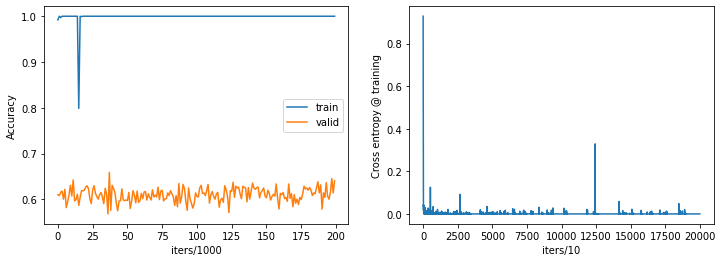

301
LR 0.001
BS 256


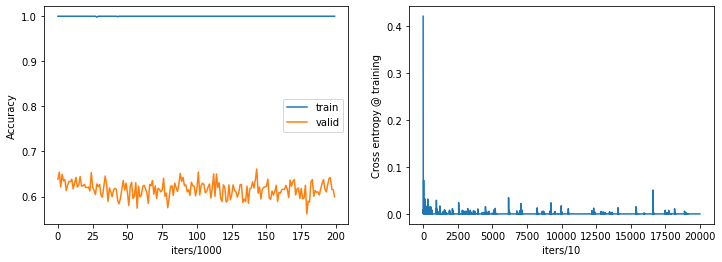

302
LR 0.0001
BS 256


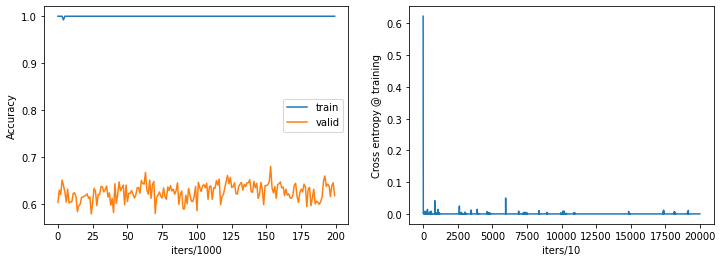

360
LR 0.005
BS 128


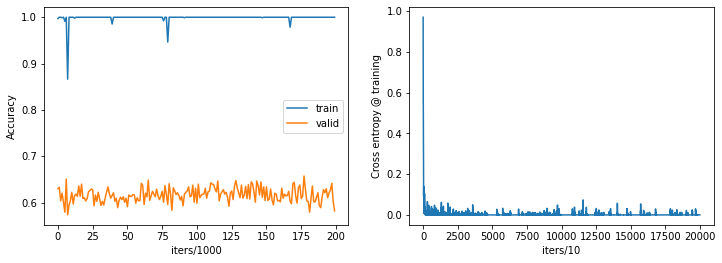

361
LR 0.001
BS 128


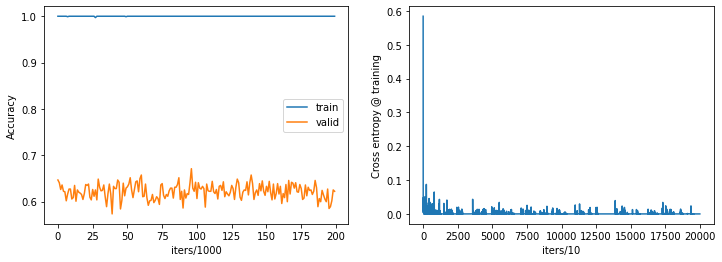

362
LR 0.0001
BS 128


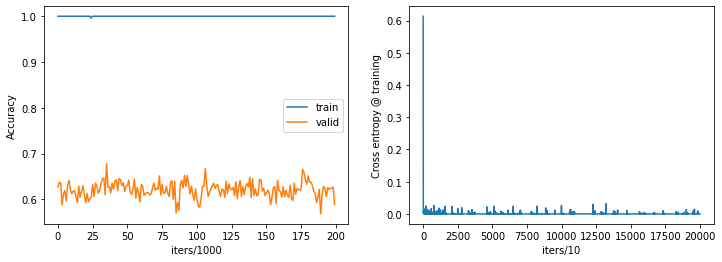

In [69]:
for id_ in idxs:
    print(id_)
    print("LR", df.iloc[id_]["hyper_opt"]["learning_rate"])
    print("BS", df.iloc[id_]["hyper_opt"]["batch_size"])
    output_path = df["output_path"][id_]
    
    json_output = json.load(open(join(output_path, "model.json"), "rb"))

    fig, ax = plt.subplots(figsize=(12, 4), ncols=2, nrows=1)
    ax[0].plot(json_output["train_accs"], label="train")
    ax[0].plot(json_output["val_accs"], label="valid")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("iters/%i" % df.iloc[id_]['hyper_opt']['checkpoint_every'])
    ax[0].legend()
    # ax[0].set_ylim([0.9,1.])

    ax[1].plot(json_output["train_losses"])
    ax[1].set_ylabel("Cross entropy @ training")
    ax[1].set_xlabel("iters/%i" % df.iloc[id_]['hyper_opt']['record_loss_every']);
    plt.show()

# With early stopping

In [ ]:
for id_ in idxs:
    print(id_)
    print("LR", df.iloc[id_]["hyper_opt"]["learning_rate"])
    print("BS", df.iloc[id_]["hyper_opt"]["batch_size"])
    output_path = df["output_path"][id_]
    
    json_output = json.load(open(join(output_path, "model.json"), "rb"))

    fig, ax = plt.subplots(figsize=(12, 4), ncols=2, nrows=1)
    ax[0].plot(json_output["train_accs"], label="train")
    ax[0].plot(json_output["val_accs"], label="valid")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Epochs/%i" % df.iloc[id_]['hyper_opt']['n_checkpoint_every_epoch'])
    ax[0].legend()

    ax[1].plot(json_output["train_losses"])
    ax[1].set_ylabel("Cross entropy @ training")
    ax[1].set_xlabel("Epochs/%i" % df.iloc[id_]['hyper_opt']['n_checkpoint_every_epoch'])
    plt.show()

# Estimate of validation accuracy

In [75]:
experiment_case = 1  # change if needed
dataset_list = ["dataset_%i" %k_ for k_ in range(15, 20)]  # datasets 

method_names = dct_hyper_method.keys()
accuracy_valid = np.zeros((len(dataset_list), len(method_names)))

for id_method, method_ in enumerate(method_names):

    dict_search = {"method_type": "SHNMN",
                   "hyper_method": pick_hyper_method(method_, experiment_case),
                   "dataset": {"experiment_case": 1}}

    for id_data, dataset_name in enumerate(dataset_list):
        dict_search["dataset"]["dataset_id"] = dataset_name
        print(dict_search)
        idxs = search_experiments(df, dict_search)
        print(idxs)
        id_, best_valid = find_best_experiment(df, idxs)
        print("id: %i" % id_)
        
        accuracy_valid[id_data, id_method] = best_valid

{'method_type': 'SHNMN', 'hyper_method': {'use_module': 'find', 'separated_stem': False, 'separated_module': False, 'separated_classifier': False, 'stem_batchnorm': 1, 'classifier_batchnorm': 1, 'feature_dim': [3, 28, 28]}, 'dataset': {'experiment_case': 1, 'dataset_id': 'dataset_15'}}
[330 331 332 390 391 392]
id: 332
{'method_type': 'SHNMN', 'hyper_method': {'use_module': 'find', 'separated_stem': False, 'separated_module': False, 'separated_classifier': False, 'stem_batchnorm': 1, 'classifier_batchnorm': 1, 'feature_dim': [3, 28, 28]}, 'dataset': {'experiment_case': 1, 'dataset_id': 'dataset_16'}}
[333 334 335 393 394 395]
id: 334
{'method_type': 'SHNMN', 'hyper_method': {'use_module': 'find', 'separated_stem': False, 'separated_module': False, 'separated_classifier': False, 'stem_batchnorm': 1, 'classifier_batchnorm': 1, 'feature_dim': [3, 28, 28]}, 'dataset': {'experiment_case': 1, 'dataset_id': 'dataset_17'}}
[336 337 338 396 397 398]
id: 337
{'method_type': 'SHNMN', 'hyper_metho

[0 1 2 3 4 5]
id: 4
{'method_type': 'SHNMN', 'hyper_method': {'use_module': 'find', 'separated_stem': True, 'separated_module': True, 'separated_classifier': True, 'stem_batchnorm': 0, 'classifier_batchnorm': 0, 'feature_dim': [3, 28, 28]}, 'dataset': {'experiment_case': 1, 'dataset_id': 'dataset_16'}}
[ 6  7  8  9 10 11]
id: 9
{'method_type': 'SHNMN', 'hyper_method': {'use_module': 'find', 'separated_stem': True, 'separated_module': True, 'separated_classifier': True, 'stem_batchnorm': 0, 'classifier_batchnorm': 0, 'feature_dim': [3, 28, 28]}, 'dataset': {'experiment_case': 1, 'dataset_id': 'dataset_17'}}
[12 13 14 15 16 17]
id: 14
{'method_type': 'SHNMN', 'hyper_method': {'use_module': 'find', 'separated_stem': True, 'separated_module': True, 'separated_classifier': True, 'stem_batchnorm': 0, 'classifier_batchnorm': 0, 'feature_dim': [3, 28, 28]}, 'dataset': {'experiment_case': 1, 'dataset_id': 'dataset_18'}}
[18 19 20 21 22 23]
id: 22
{'method_type': 'SHNMN', 'hyper_method': {'use_m

In [78]:
len(method_names)

7

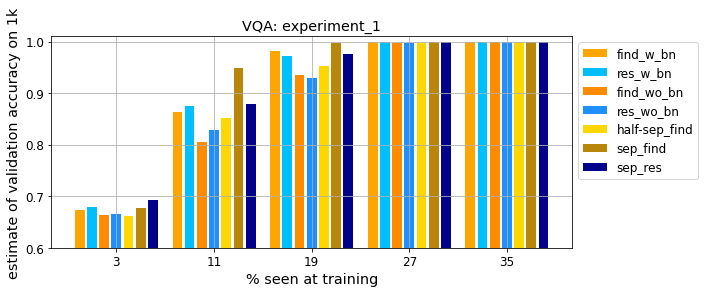

In [79]:
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

fig, ax = plt.subplots(figsize=(10, 4))

n_mts = len(method_names)
n_data = len(dataset_list)

color_list = ["orange", "deepskyblue", 
              "darkorange", "dodgerblue",
              "gold", "darkgoldenrod",
              "darkblue"]
for i, key_ in enumerate(method_names):
    ax.bar([n_mts*(k_)+i + k_ for k_ in range(n_data)], 
           accuracy_valid[:, i], color=color_list[i], label=key_)
    
ax.set_xticks([n_mts*k_+n_mts//2+k_ for k_ in range(n_data)])
ax.set_xlabel("% seen at training", fontsize='x-large')
ax.set_title("VQA: experiment_%i" % experiment_case, fontsize='x-large')
ax.legend(fontsize="large", bbox_to_anchor=(1, 1), loc='upper left')
ax.set_ylabel("estimate of validation accuracy on 1k", fontsize='x-large')
ax.grid()
ax.set_ylim([0.6,1.01])
plt.tight_layout()
plt.show()
plt.close()